Jonathan Espinoza 20022

Juan Andrés Galicia 20298

Oscar Méndez 20402

Juan Fernando Ramírez 20666

Jeyner Arango 201106


# Laboratorio 1

In [63]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib

## Análisis Exploratorio de Datos

In [12]:
df = pd.read_csv('data/train.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


Primero miramos los tipos de datos que tenemos en la columnas, y si existen nulos que tratar. En este caso no hay nulos en ninguna columna y todas son numéricas.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

Miramos la cantidad de valores distintos, para ver si hace sentido analizaros como variables categóricas o como numéricas.

In [15]:
df.nunique()

battery_power    1094
blue                2
clock_speed        26
dual_sim            2
fc                 20
four_g              2
int_memory         63
m_dep              10
mobile_wt         121
n_cores             8
pc                 21
px_height        1137
px_width         1109
ram              1562
sc_h               15
sc_w               19
talk_time          19
three_g             2
touch_screen        2
wifi                2
price_range         4
dtype: int64

In [28]:
continuous_cols = [
    'battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt',
    'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time'
]

discrete_cols = [
    'blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi'
]

Ahora exploramos la variable de respuesta

In [14]:
df['price_range'].value_counts()

1    500
2    500
3    500
0    500
Name: price_range, dtype: int64

## Incidencia de Variables

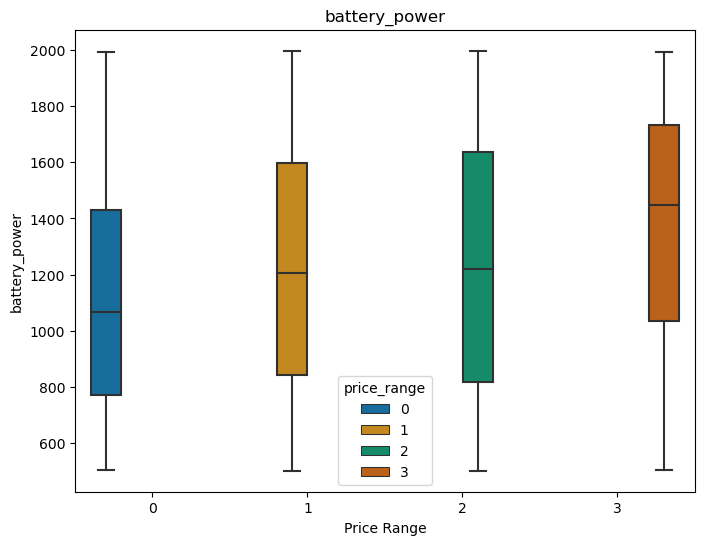

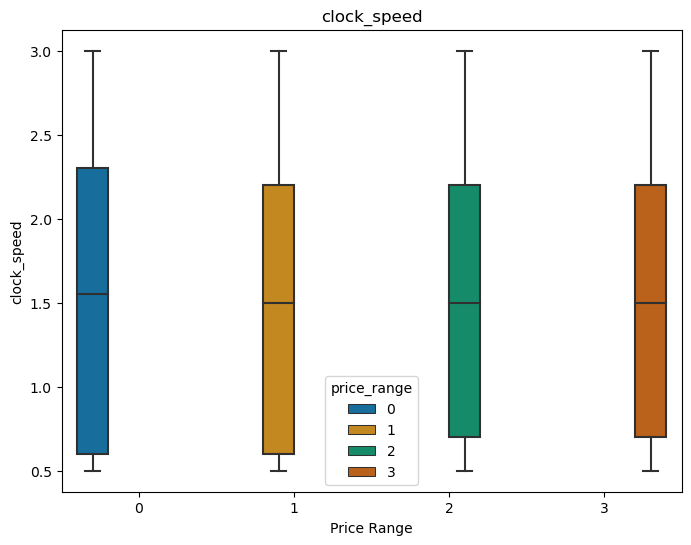

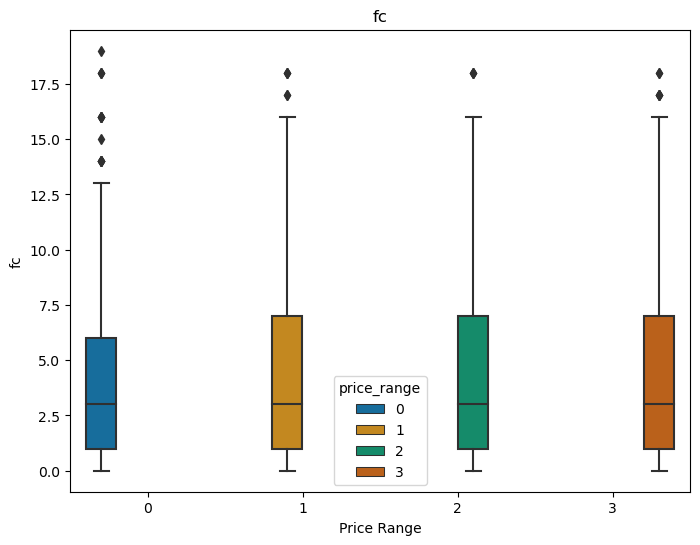

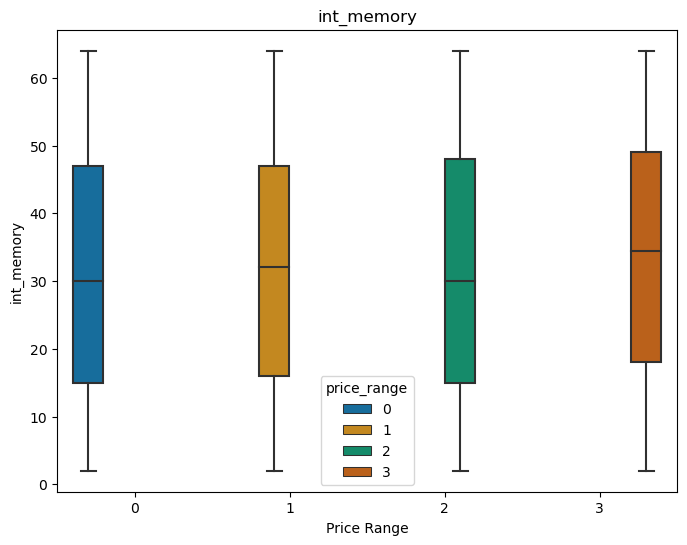

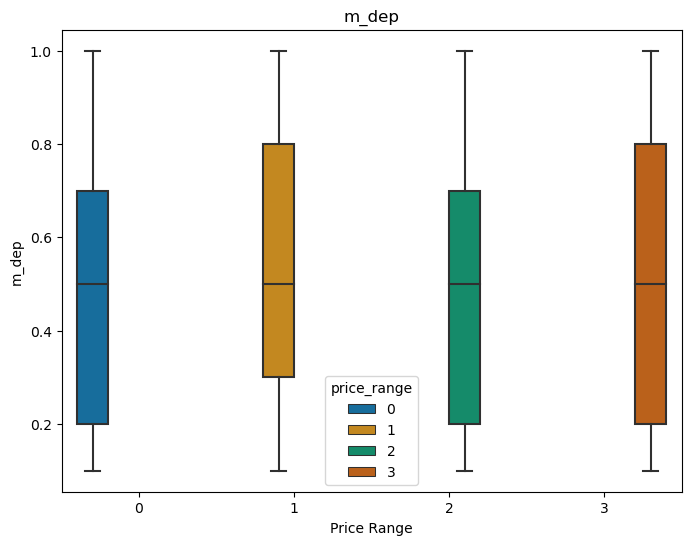

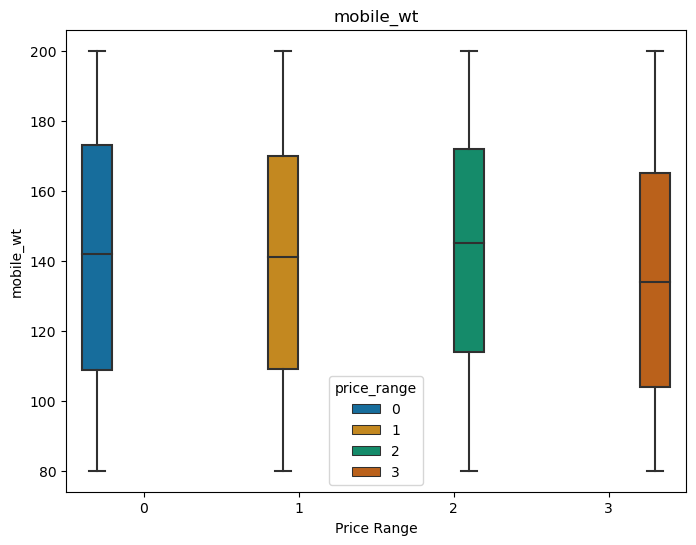

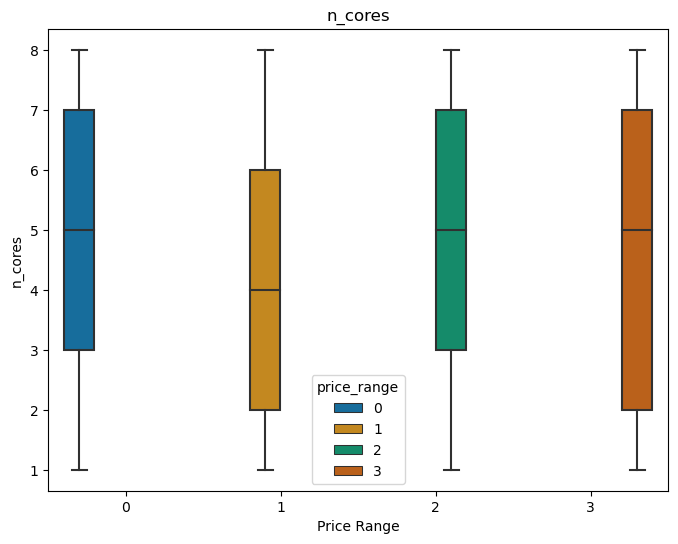

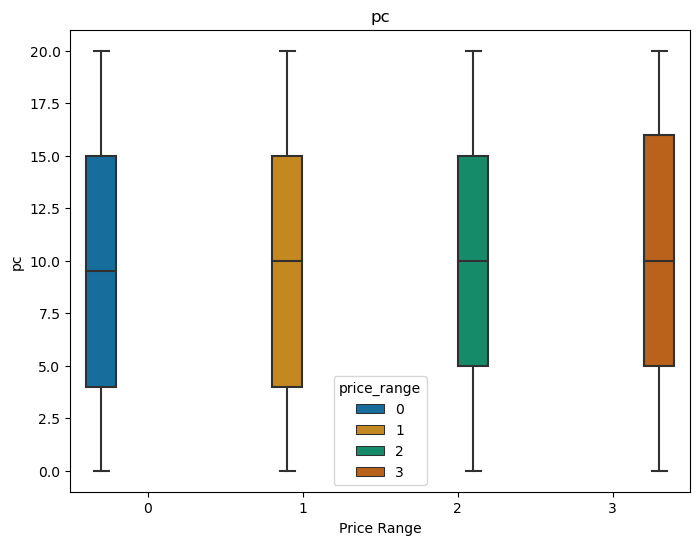

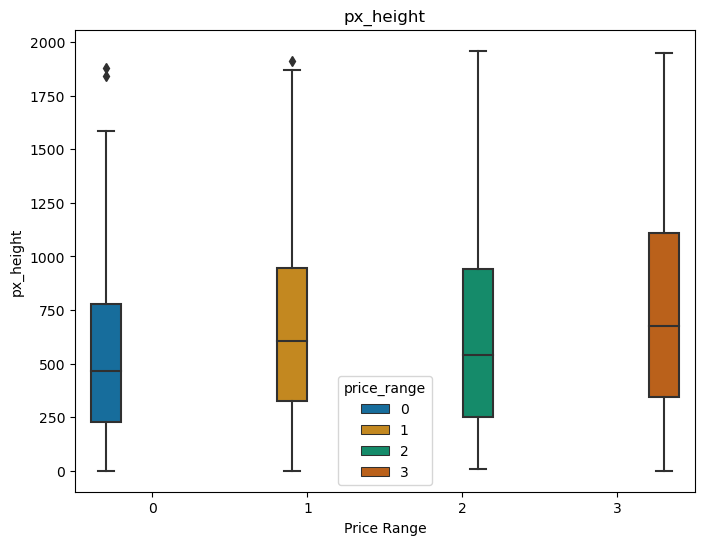

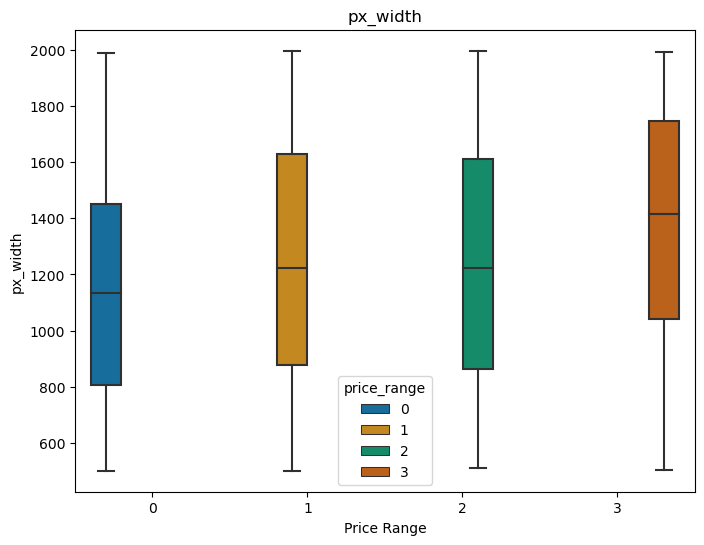

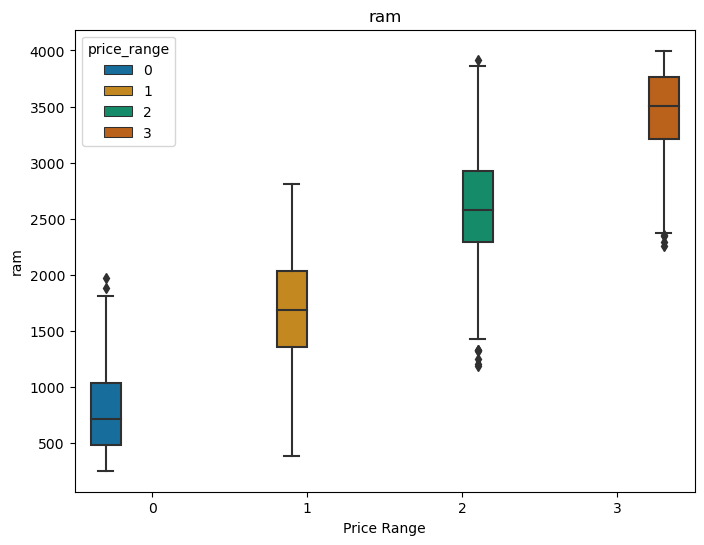

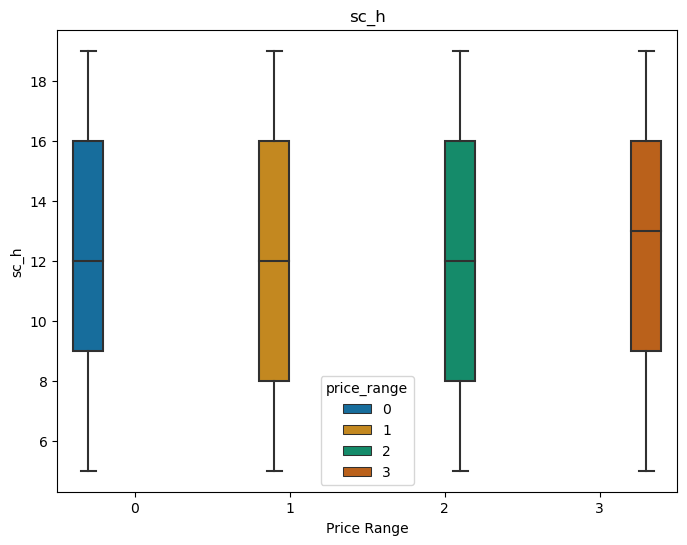

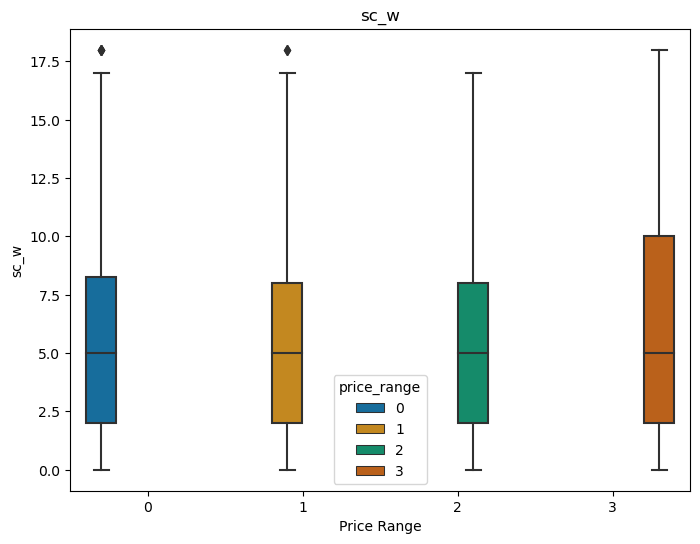

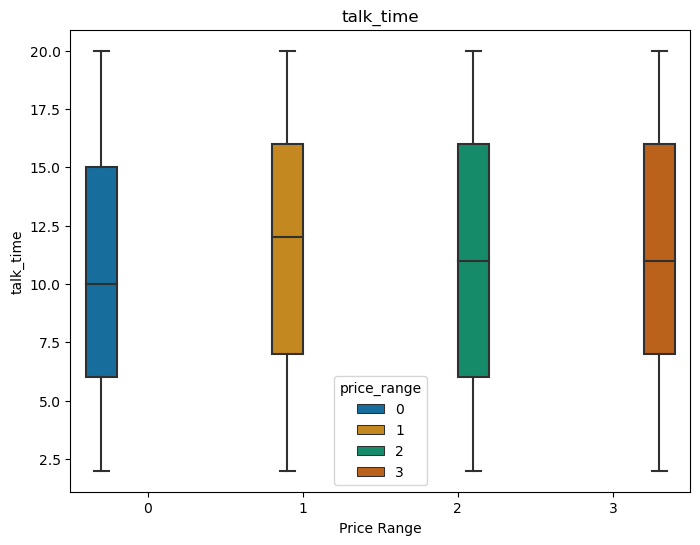

In [30]:
for col in continuous_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='price_range', y=col, data=df, hue='price_range', palette='colorblind')
    plt.title(col)
    plt.xlabel('Price Range')
    plt.show()

<Figure size 800x600 with 0 Axes>

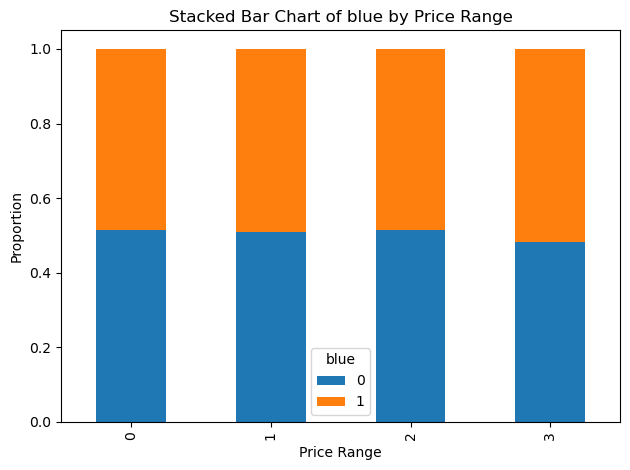

<Figure size 800x600 with 0 Axes>

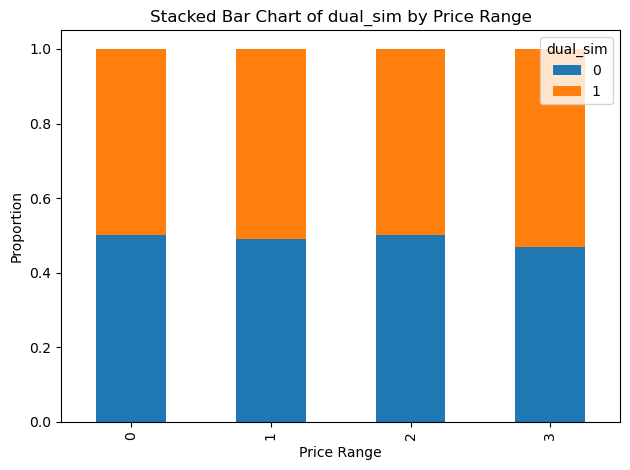

<Figure size 800x600 with 0 Axes>

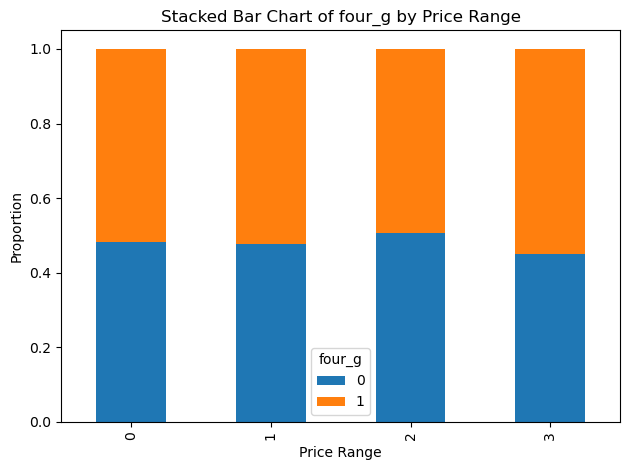

<Figure size 800x600 with 0 Axes>

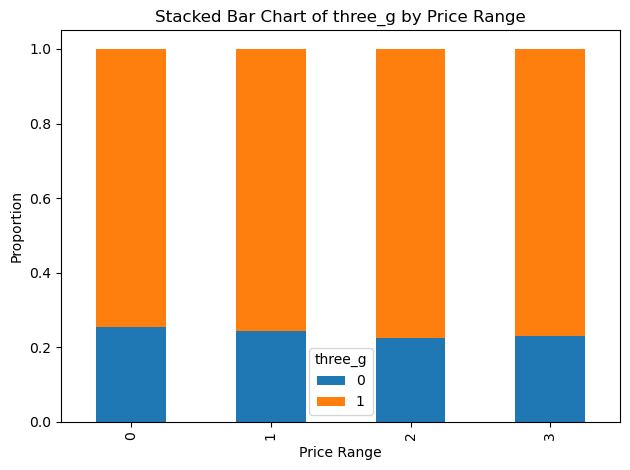

<Figure size 800x600 with 0 Axes>

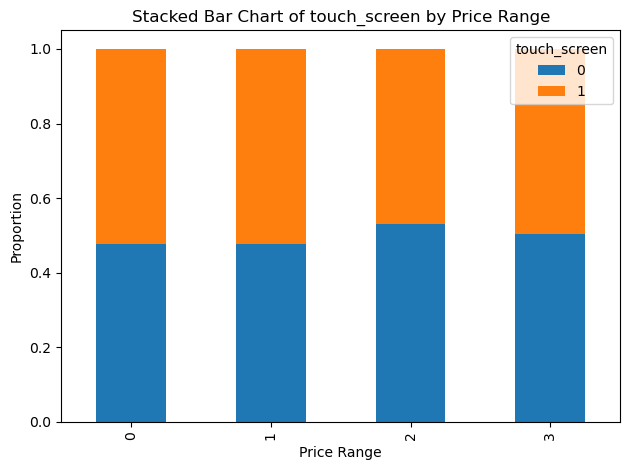

<Figure size 800x600 with 0 Axes>

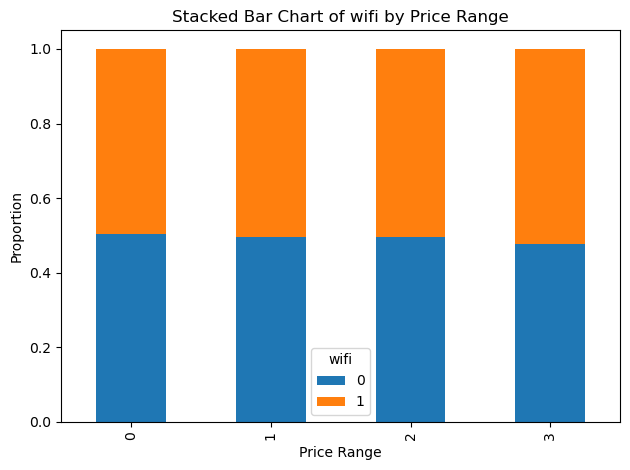

In [31]:
for col in discrete_cols:
    plt.figure(figsize=(8, 6))
    # Calculate proportions for 100% stacked bars
    counts = df.groupby(['price_range', col]).size().unstack().fillna(0)
    proportions = counts.div(counts.sum(axis=1), axis=0) 
    proportions.plot(kind='bar', stacked=True)
    plt.title(f'Stacked Bar Chart of {col} by Price Range')
    plt.xlabel('Price Range')
    plt.ylabel('Proportion')
    plt.legend(title=col)
    plt.tight_layout()
    plt.show()

No hay muchas relaciones lineales, por lo que usaremos un modelo no lineal. Utilizaremos GBTs debido a que estos rinden muy bien cuando hay mezcla de datos discretos, booleanos y continuos.

## Preprocesamiento

Como los datos ya vienen limpios, no hay variables multicategóricas, y no existen outliers significativos, no es necesario reaizar ningún tipo de preprocesamiento. Además, los árboles son muy robustos por lo que no hay necesidad de tratar los datos de alguna forma.

## Modelo Sencillo

In [90]:
X = df.drop('price_range', axis=1)
y = df['price_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=11)

In [91]:
dt_model = DecisionTreeClassifier(max_depth=7, random_state=11)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=11)

In [100]:
y_pred = dt_model.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       100
           1       0.82      0.80      0.81       100
           2       0.67      0.70      0.69       100
           3       0.79      0.77      0.78       100

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



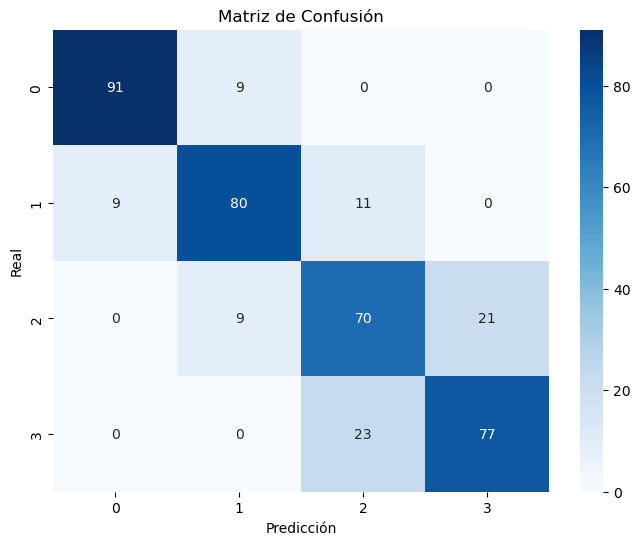

In [101]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

## Tuneo de Hiperparámetros

In [93]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

param_dist = {
    'n_estimators': np.arange(50, 201, 10),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gamma': np.arange(0, 1.1, 0.1)
}

scorer = make_scorer(f1_score, average='macro')
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scorer,
    cv=5,
    verbose=1,
    random_state=11,
    n_jobs=-1
)

In [94]:
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores hiperparámetros: {'n_estimators': 110, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.1}


## Modelo Final

In [95]:
joblib.dump(random_search.best_estimator_, 'models/xgb_best_model.pkl')

['models/xgb_best_model.pkl']

In [96]:
loaded_model = joblib.load('models/xgb_best_model.pkl')

## Evaluación del Modelo

In [102]:
y_pred = loaded_model.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       100
           1       0.90      0.92      0.91       100
           2       0.87      0.83      0.85       100
           3       0.89      0.92      0.91       100

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



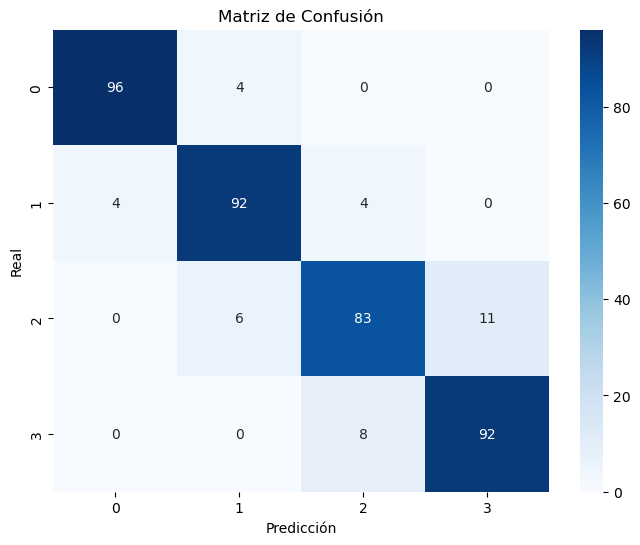

In [103]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()